In [19]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch as th
import torch.nn as nn
import math

In [20]:
device = th.device("cuda" if th.cuda.is_available() else "cpu")

In [21]:

dt = 0.01
max_time = 10

In [22]:
def lotka_volterra(x, y, alpha, beta, gamma, delta, dt):
    dx = (alpha * x - beta * x * y) * dt
    dy = (-gamma * y + delta * x * y) * dt
    return x + dx, y + dy


def simulate_lotka_volterra(alpha, beta, gamma, delta, x0, y0, steps, dt, max_steps):
    x, y = x0, y0
    dt = th.tensor([dt] * len(steps))
    for i in range(max_steps):
        dt = th.where(steps > i, dt, 0)
        x, y = lotka_volterra(x, y, alpha, beta, gamma, delta, dt)

    return x, y

In [23]:
def data_generator(num_samples):

    max_steps = 10
    steps = th.tensor(np.random.randint(1, max_steps, num_samples))

    x0 = th.tensor(np.random.randint(1, 40, num_samples))
    y0 = th.tensor(np.random.randint(1, 40, num_samples))
    alpha = th.tensor(np.random.uniform(0.5, 1.5, num_samples))
    gamma = th.tensor(np.random.uniform(0.01, 0.5, num_samples))
    beta = th.tensor(np.random.uniform(0.01, 0.5, num_samples))
    delta = th.tensor(np.random.uniform(0.01, 0.05, num_samples))

    x, y = simulate_lotka_volterra(
        alpha, beta, gamma, delta, x0, y0, steps, dt, max_steps
    )
    x = x.unsqueeze(1)
    y = y.unsqueeze(1)
    steps = steps.unsqueeze(1)
    x0 = x0.unsqueeze(1)
    y0 = y0.unsqueeze(1)
    alpha = alpha.unsqueeze(1)
    gamma = gamma.unsqueeze(1)
    beta = beta.unsqueeze(1)
    delta = delta.unsqueeze(1)
    obs = th.cat([x, y], dim=1)
    state = th.cat([x0, y0, steps, alpha, beta, gamma, delta], dim=1)

    return state, obs

In [24]:
class SimpleFCNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(SimpleFCNN, self).__init__()
        self.relu = nn.ReLU()
        # initialize the first layer
        self.first_layer = nn.Linear(input_size, hidden_size)
        self.num_layers = num_layers
        # initialize the layers
        for i in range(num_layers - 2):
            setattr(self, f"fc{i}", nn.Linear(hidden_size, hidden_size))

        # initialize last layer extra
        self.last_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # apply first layer
        x = self.relu(self.first_layer(x))
        # iterate over all layers but the last one
        for i in range(self.num_layers - 2):
            x = self.relu(getattr(self, f"fc{i}")(x))
        # apply last layer without relu
        x = self.last_layer(x)
        return x

class CouplingLayer(nn.Module):
    def __init__(self, num_features, hidden_size, num_layers, num_conds):
        super(CouplingLayer, self).__init__()
        # Initialize the fully connected network
        upper_split_size = math.ceil(num_features / 2)
        lower_split_size = num_features - upper_split_size
        # self.t = SimpleFCNN(
        #     upper_split_size, hidden_size, 2*lower_split_size, num_layers
        # )
        self.s = SimpleFCNN(
            upper_split_size + num_conds, hidden_size, 2*lower_split_size, num_layers
        )

    def forward(
        self,
        x,
        cond,
    ):
        x_1, x_2 = th.tensor_split(x, 2, dim=1)
        x_1_tilde = th.cat((x_1, cond), dim=1)
        s, t = th.tensor_split(self.s(x_1_tilde), 2, dim=1)
        # Forward pass through the coupling layer
        x_2 = th.abs(s) * x_2 + t
        log_det_J = th.sum(th.log(th.abs(s)), dim=1)
        return th.cat((x_1, x_2), dim=1), log_det_J

    def backward(self, x, cond):
        x_1, x_2 = th.tensor_split(x, 2, dim=1)
        x_1_tilde = th.cat((x_1, cond), dim=1)
        s, t = th.tensor_split(self.s(x_1_tilde), 2, dim=1)
        # Forward pass through the coupling layer
        x_2 = (x_2 - t) / th.abs(s)
        return th.cat((x_1, x_2), dim=1)

class CINN(nn.Module):
    def __init__(self, num_blocks, num_features, hidden_size, num_layers, cond_hidden_size, cond_num_layers, num_conditions=2):
        super(CINN, self).__init__()

        self.num_blocks = num_blocks


        for i in range(num_blocks - 1):
            setattr(
                self,
                f"cl_{i}",
                CouplingLayer(
                    num_features, hidden_size, num_layers, num_conds = 4* num_conditions),
            )

        self.last_block = CouplingLayer(
            num_features, hidden_size, num_layers, num_conds = 4* num_conditions
        )

        self.condition = SimpleFCNN(num_conditions, cond_hidden_size, 4* num_conditions*num_blocks, cond_num_layers)

    def forward(self, x, cond):
        log_det_J = 0
        conds = self.condition.forward(cond)
        conds = th.tensor_split(conds, self.num_blocks, dim=1)
        for i in range(self.num_blocks - 1):
            x, _log_det_J = getattr(self, f"cl_{i}").forward(x, conds[i])
            x = x[:,[2, 6, 3, 1, 0, 4, 5]]
            log_det_J += _log_det_J
            
        x, _log_det_J = self.last_block.forward(x, conds[-1])
        log_det_J += _log_det_J
        return x, log_det_J

    def backward(self, x, cond):
        conds = self.condition.forward(cond)
        conds = th.tensor_split(conds, self.num_blocks, dim=1)
        x = self.last_block.backward(x, conds[-1])
        for i in range(self.num_blocks - 2, -1, -1):
            x = x[:,[4, 3, 0, 2, 5, 6, 1]]
            x = getattr(self, f"cl_{i}").backward(x, conds[i])
        return x
    


In [25]:
class Loss(nn.Module):
    def __init__(self):
        super(Loss, self).__init__()
    
    def Isotropic_Gaussian(self, x):
        xx = th.sum(x ** 2, axis=1)    
        return -0.5 * (xx - 2*th.log(th.tensor(2 * th.pi)))

    def forward(self, x, log_det_J, model, y, lambda_1 = 1e-3):
        mse_penalty = th.nn.MSELoss(size_average=False)
        reg_loss = 0

        mseloss =th.nn.MSELoss(size_average=False)
        n = x.shape[0]
        
        for param in model.parameters():
            reg_loss += mse_penalty(param, th.zeros_like(param)) #
        return -th.sum(self.Isotropic_Gaussian(x) + log_det_J),  -th.sum(self.Isotropic_Gaussian(x) + log_det_J)

In [26]:
num_features = 7  # Number of features in the input
hidden_size = 8  # Number of hidden units in the FCNN
num_layers = 8  # Number of layers in the FCNN
num_blocks = 16  # Number of coupling layers in the flow
num_conditions = 2  # Number of conditions
cond_hidden_size = 16  # Number of hidden units in the FCNN for the conditions
cond_num_layers = 4  # Number of layers in the FCNN for the conditions


# Initialize the flow
flow = CINN(num_blocks, num_features, hidden_size, num_layers, cond_hidden_size, cond_num_layers, num_conditions)

# Initialize the loss
lossfunc = Loss()
flow.to(device)
loss_arr = []

n = 1000
x, y = data_generator(n)

In [27]:
optimizer = th.optim.RMSprop(
    [
        {"params": flow.parameters(), "lr": 1e-4},
    ]
)
dataloader = th.utils.data.DataLoader(list(zip(x, y)), batch_size=2000, shuffle=True)
# sheduler = th.optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.1)
for i in range(25001):
    epochloss = 0
    epochcounter = 0
    epochcleanedloss = 0
    for x_batch , y_batch in dataloader:
        optimizer.zero_grad()
        loss = 0.0
        y_pred, log_det_J = flow.forward(x_batch.float(), y_batch.float())
        loss, cleaned_loss = lossfunc.forward(y_pred.float(), log_det_J, flow, y_batch.float())
        epochloss += loss
        epochcleanedloss += cleaned_loss
        epochcounter += 1
        loss_arr.append(cleaned_loss.cpu().item())
        loss.backward()

        optimizer.step()
        # sheduler.step()
    if i % 100 == 0:
        print("Epoch: " + str(i) + " Loss: " + str(epochloss.item()/epochcounter))


Epoch: 0 Loss: 102279.53125
Epoch: 100 Loss: 77421.125
Epoch: 200 Loss: 68071.078125
Epoch: 300 Loss: 56700.90625
Epoch: 400 Loss: 40939.890625
Epoch: 500 Loss: 24379.12890625
Epoch: 600 Loss: 12682.7548828125
Epoch: 700 Loss: 7412.47314453125
Epoch: 800 Loss: 5704.921875
Epoch: 900 Loss: 4332.74560546875
Epoch: 1000 Loss: 3113.1064453125
Epoch: 1100 Loss: 2059.241943359375
Epoch: 1200 Loss: 1440.195556640625
Epoch: 1300 Loss: 1073.9405517578125
Epoch: 1400 Loss: 670.8994140625
Epoch: 1500 Loss: 120.38652038574219
Epoch: 1600 Loss: 194.062744140625
Epoch: 1700 Loss: -510.8970947265625
Epoch: 1800 Loss: -835.248046875
Epoch: 1900 Loss: -1156.0435791015625
Epoch: 2000 Loss: -1363.7633056640625
Epoch: 2100 Loss: -1667.402099609375
Epoch: 2200 Loss: -1721.9066162109375
Epoch: 2300 Loss: -1959.1566162109375
Epoch: 2400 Loss: -2170.1396484375
Epoch: 2500 Loss: -2332.20703125
Epoch: 2600 Loss: -2470.13427734375
Epoch: 2700 Loss: -2584.681884765625
Epoch: 2800 Loss: -2713.470458984375
Epoch: 2

Text(0, 0.5, 'Negative Log Likelihood')

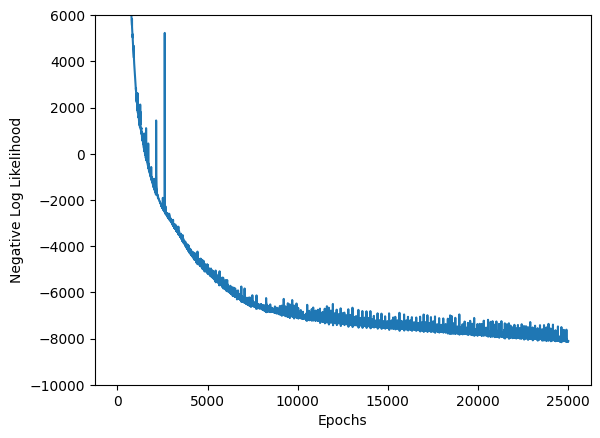

In [28]:
plt.plot(loss_arr)
plt.ylim(-10000, 6000)
plt.xlabel("Epochs")
plt.ylabel("Negative Log Likelihood")

0.01


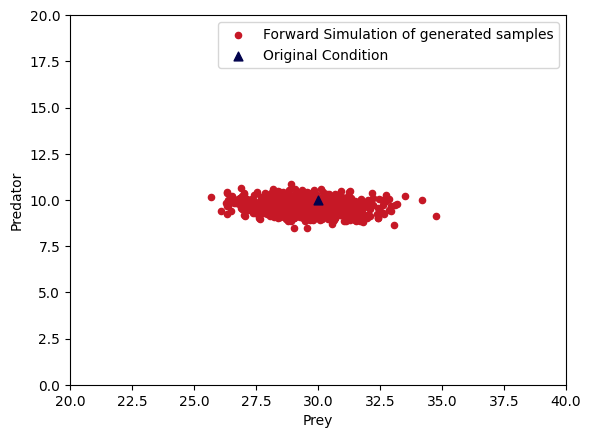

In [29]:
n = 1000
target = [30.0, 10.0]
samples = th.tensor(np.random.normal([0, 0, 0, 0, 0, 0, 0], 1, size = (n, 7))).to(device)
y = [target] * n
y = th.tensor(y).to(device)
result = flow.backward(samples.float(), y.float()).detach()

print(dt)
import matplotlib.pyplot as plt
result_x, result_y = simulate_lotka_volterra(result[:, 3], result[:, 4], result[:, 5], result[:, 6], result[:, 0], result[:, 1], result[:, 2], dt, 10)
col_red = '#c61826'
col_dark_red = '#590d08'
col_blue = '#01024d'
plt.scatter(result_x, result_y, s = 20, c = col_red, alpha = 1, label='Forward Simulation of generated samples')
plt.scatter(target[0], target[1], marker = '^',s = 40, alpha = 1, c=col_blue, label='Original Condition')
plt.xlim(target[0]-10, target[0]+10)
plt.ylim(target[1]-10, target[1]+10)
plt.xlabel('Prey')
plt.ylabel('Predator')
plt.legend()


In [30]:
print(np.mean(result_x.detach().numpy()), np.mean(result_y.detach().numpy()))

29.471006 9.680332


In [31]:
concatenated_array = th.stack([result_x, result_y])
print(th.cov(concatenated_array))

tensor([[ 1.7016, -0.0888],
        [-0.0888,  0.1205]])


In [32]:
print(np.mean(np.sqrt((result_x.detach().numpy() - target[0])**2 + (result_y.detach().numpy() - target[1])**2)))

1.2672983


In [33]:
print(np.max(np.sqrt((result_x.detach().numpy() - target[0])**2 + (result_y.detach().numpy() - target[1])**2)))

4.8232484


In [34]:
print(np.min(np.sqrt((result_x.detach().numpy() - target[0])**2 + (result_y.detach().numpy() - target[1])**2)))

0.04243386


In [35]:
def MMD(x, y):
        gamma = 2
        xx, yy, zz = th.mm(x, x.t()), th.mm(y, y.t()), th.mm(x, y.t())
        rx = (xx.diag().unsqueeze(0).expand_as(xx))
        ry = (yy.diag().unsqueeze(0).expand_as(yy))

        dxx = rx.t() + rx - 2. * xx # Used for A in (1)
        dyy = ry.t() + ry - 2. * yy # Used for B in (1)
        rxx = rx[0].repeat(y.shape[0], 1)
        ryy = ry[0].repeat(x.shape[0], 1) 
        dxy = rxx.t() + ryy - 2. * zz # Used for C in (1)

        XX, YY, XY = (th.zeros(xx.shape).to(device),
                      th.zeros(yy.shape).to(device),
                      th.zeros(zz.shape).to(device))
        XX += 1/(1 + dxx/gamma**2)
        YY += 1/(1 + dyy/gamma**2)
        XY += 1/(1 + dxy/gamma**2)
        return XX.mean() + YY.mean() - 2*XY.mean()

In [36]:
print(MMD(x.float(), result.float()))

tensor(0.2589)
